## Experiment Containers
The experiment container describes a set of experiments performed with the same targeted area, imaging depth, and Cre line.  The `BrainObservatoryCache` has a number of functions for figuring out what experiment containers are available at the moment.

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [2]:
# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

all VISp experiment containers: 144


In [3]:
# Download a list of all stimuli
stims = boc.get_all_stimuli()
print("all stimuli:\n")
pprint.pprint(stims)

all stimuli:

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']


## Download Experiments for a Container
An experiment container is a group of experiments.  Each experiment has a different stimulus protocol.  For example, one experiment protocol contains the static gratings stimulus and another has the natural scenes stimulus.  The `BrainObservatoryCache` helps you find out which experiment associated with a container has the stimuli you are interested in.  First, let's see what experiments are available for a single container.

## Find Cells of Interest
Another way to look for data is to search for cells with interesting tuning properties.  We have pre-computed a set of cell metrics.  Take a look at <a href='http://alleninstitute.github.io/AllenSDK/brain_observatory_metrics.html'>this page</a> to see the full list.

You can use these properties to filter the full set of cells down to the set your are interested in.

In [4]:
import pandas as pd

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find orientation selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to static gratings stimulus
sig_cells = visp_cells[visp_cells['p_sg'] < 0.05]
print("cells with sig. response to static gratings: %d" % len(sig_cells))

# direction selective cells
osi_cells = sig_cells[(sig_cells['g_osi_sg'] > 0.99)]
print("direction-selective cells: %d" % len(osi_cells))

total cells: 63251
VISp cells: 22641
cells with sig. response to static gratings: 13322
direction-selective cells: 350


## Find Experiments for Cells
Once you have found a set of cells you would like to investigate, you can use the `BrainObservatoryCache` to find the experiments for those cells that contain the relevant stimulus.

In [5]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
osi_ec_ids = osi_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(osi_ec_ids))
pprint.pprint(osi_ec_ids)

# Download the ophys experiments containing the static gratings stimulus for VISp experiment containers
osi_exps = boc.get_ophys_experiments(experiment_container_ids=osi_ec_ids, stimuli=[stim_info.STATIC_GRATINGS])
print("VISp drifting gratings ophys experiments: %d" % len(osi_exps))

print("Example ophys experiment:")
pprint.pprint(osi_exps[0])

total dsi experiment containers: 79
array([511498742, 511507811, 511507650, 511509529, 511510650, 511510718,
       511510670, 511510911, 512124562, 511510736, 511510667, 511510896,
       511510855, 511510699, 511510779, 511510675, 511510989, 524691282,
       531134088, 528889127, 526481129, 530739574, 517328083, 527676429,
       538803515, 528792730, 539291370, 540168835, 540993888, 536323956,
       555040113, 561312433, 546724786, 545578995, 571137444, 543677425,
       586351979, 575827179, 590168381, 595906107, 595263152, 595806298,
       617381603, 637671552, 603425700, 616886391, 642651896, 637998953,
       627823571, 647155120, 645413757, 644909309, 648377366, 653122665,
       652842570, 650389885, 653932503, 653125128, 656939125, 657082052,
       657390169, 659746623, 657016265, 662974313, 661437138, 666589599,
       660065749, 661744802, 658536109, 659767480, 674802081, 682734790,
       680156909, 679702882, 688678764, 702934962, 701412138, 686912320,
       71217850

## Download Experiment Data for a Cell
Once you have some experiments, you can download the NWB files that contain the fluorescence traces for segmented cells in those experiments.

In [6]:
# pick an orientation-selective cell and find its NWB file
osi_cell = osi_cells.iloc[0]

# figure out which ophys experiment has the static gratings stimulus for that cell
cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[osi_cell['cell_specimen_id']],
                                     stimuli=[stim_info.STATIC_GRATINGS])[0]

data_set = boc.get_ophys_experiment_data(cell_exp['id'])


In [7]:
from allensdk.brain_observatory.static_gratings import StaticGratings

sg = StaticGratings(data_set)

In [8]:
sg.get_response().shape

171

In [22]:
import xarray as xr

d = xr.DataArray(
    sg.get_response(), 
    dims=("orientation", "sf", "phase", "cell", "type"), 
    coords={
        "orientation": sg.orivals, 
        "sf" : sg.sfvals, 
        "phase" : sg.phasevals,
        "type" : ['mean', 'sem', "n_sig_trials"]})

KeyboardInterrupt: 

In [84]:
s = d.sel(type="mean")

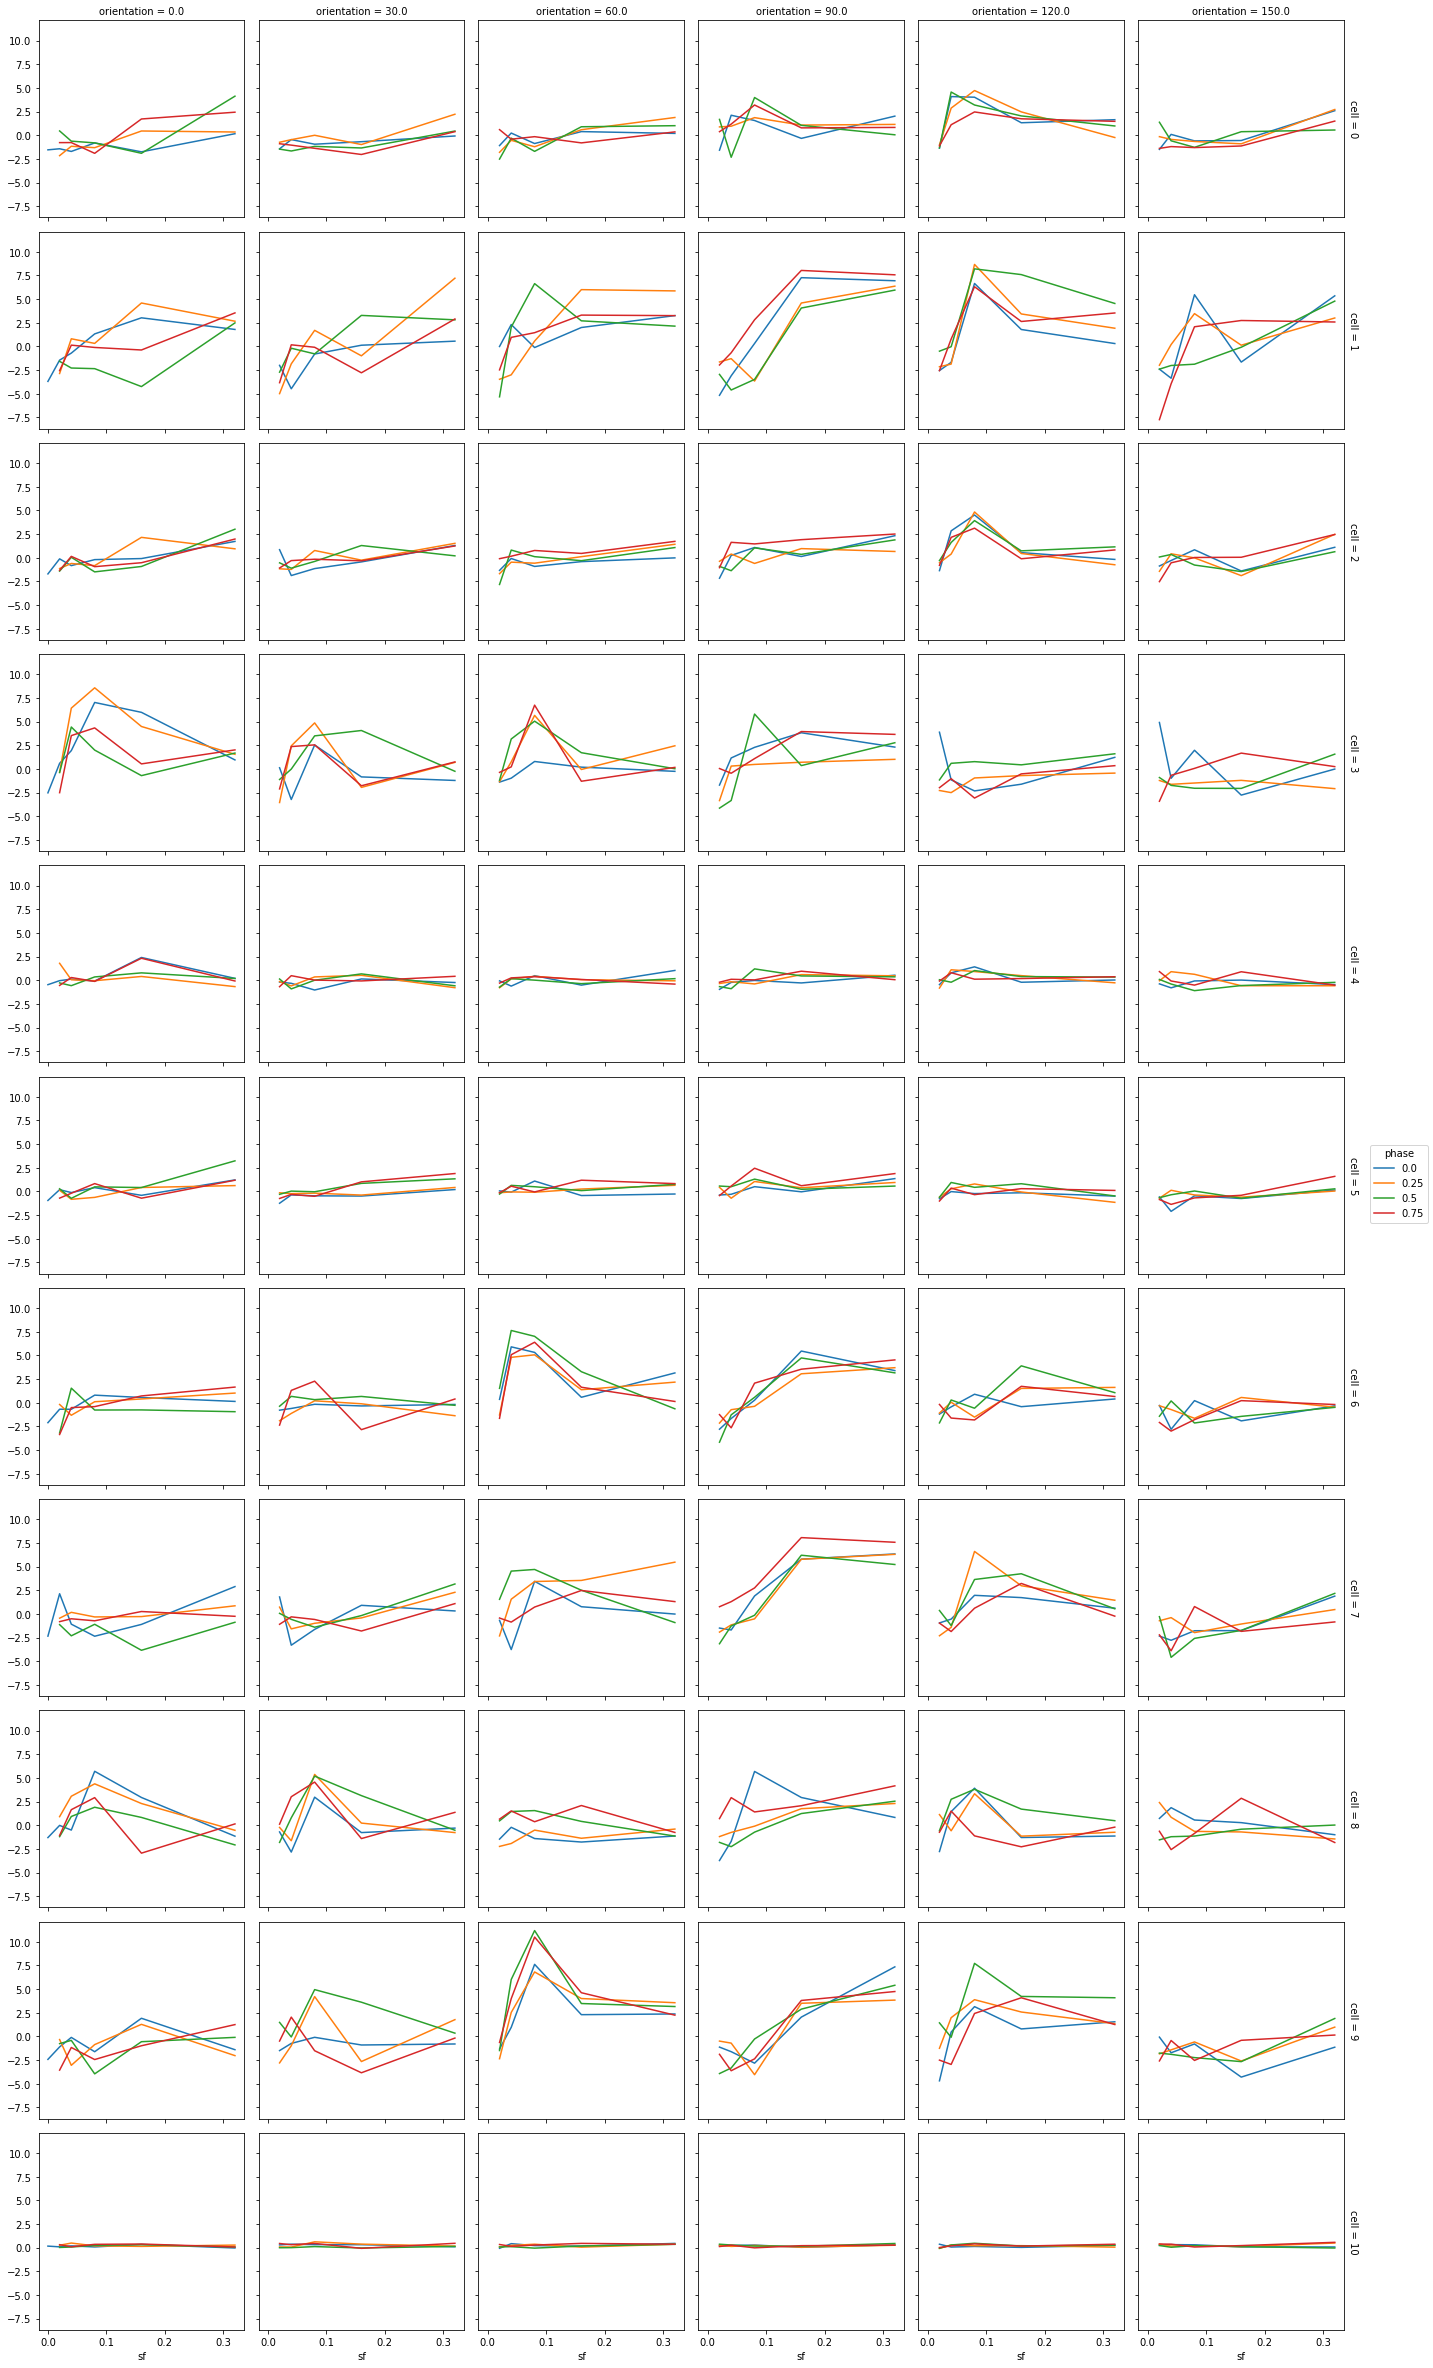

In [86]:
s.sel(phase=[0.0,0.25,0.5,0.75]).plot.line(x="orientation", col="sf", row="cell")